In [22]:
import pandas as pd
import requests
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import seaborn as sns

In [2]:
collision_uk_2023 = pd.read_csv(
    'https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-2023.csv', 
    low_memory=False
)
casualty_uk_2023 = pd.read_csv(
    'https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-casualty-2023.csv', 
    low_memory = False
)
ped_index = casualty_uk_2023[casualty_uk_2023['casualty_type'] == 0][['accident_reference', 'casualty_type']]

index=ped_index['accident_reference'].unique()

collision_ped = collision_uk_2023[collision_uk_2023['accident_reference'].isin(index)]

collision_ped = collision_ped[[
    'accident_reference', 
    'longitude',
    'latitude',
    'number_of_casualties',
    'speed_limit'
]].copy()

CollisionClean = collision_ped.dropna()

In [3]:
district_population = pd.read_excel('population by borough.xlsx')
district_population = district_population.set_index('GSS_CODE')
district_population.head()

name     population
GSS_CODE                                      
E09000001        City of London    8503.050827
E09000002  Barking and Dagenham  233095.228667
E09000003                Barnet  419517.213165
E09000004                Bexley  253518.280320
E09000005                 Brent  357609.208033

In [4]:
url = 'https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true'
file_name = 'Boroughs.gpkg'
response = requests.get(url)
with open (file_name, 'wb') as file:
    file.write(response.content)
boroughs = gpd.read_file(file_name)

In [5]:
geometry = [Point(xy) for xy in zip(collision_ped['longitude'], collision_ped['latitude'])]
collision_gdf = gpd.GeoDataFrame(collision_ped, geometry=geometry)

In [6]:
collision_gdf.set_crs("EPSG:4326", inplace=True)
collision_gdf = collision_gdf.to_crs(boroughs.crs)
gdf_join = gpd.sjoin(collision_gdf, boroughs, how='inner', predicate='within')

In [7]:
gdf_join.head()

accident_reference  longitude   latitude  number_of_casualties  \
0           010419171  -0.202878  51.418974                     1   
5           010419198  -0.201941  51.545349                     1   
8           010419209  -0.072322  51.583379                     1   
17          010419274  -0.123808  51.579187                     1   
18          010419278  -0.095656  51.570757                     1   

    speed_limit                       geometry  index_right      NAME  \
0            20  POINT (525058.263 170416.237)           20    Merton   
5            30  POINT (524778.276 184470.919)           25    Camden   
8            20  POINT (533654.245 188928.888)           29  Haringey   
17           20  POINT (530099.254 188369.845)           29  Haringey   
18           30  POINT (532074.203 187482.865)           28   Hackney   

     GSS_CODE  HECTARES  NONLD_AREA ONS_INNER  
0   E09000024  3762.466         0.0         F  
5   E09000007  2178.932         0.0         T  
8   E09000014  2959.837         0.0         T  
17  E09000014  2959.837         0.0         T  
18  E09000012  1904.902         0.0         T

In [8]:
accident_count = gdf_join.groupby('index_right').size()
casualty_sum = gdf_join.groupby('index_right')['number_of_casualties'].sum()
boroughs['accident_count'] = boroughs.index.map(accident_count.to_dict()).fillna(0)
boroughs['casualty_sum'] = boroughs.index.map(casualty_sum.to_dict()).fillna(0)

In [16]:
accident = boroughs[['NAME','GSS_CODE','accident_count','casualty_sum','geometry','HECTARES']]
accident = accident.set_index('GSS_CODE')
accident['population'] = district_population['population']
accident['accident_density'] = accident['accident_count']/accident['HECTARES']
accident['casualty_rate'] = accident['casualty_sum']/accident['population']
scaler = StandardScaler()
accident[['accident_density_z','casualty_rate_z']] = scaler.fit_transform(accident[['accident_density', 'casualty_rate']])

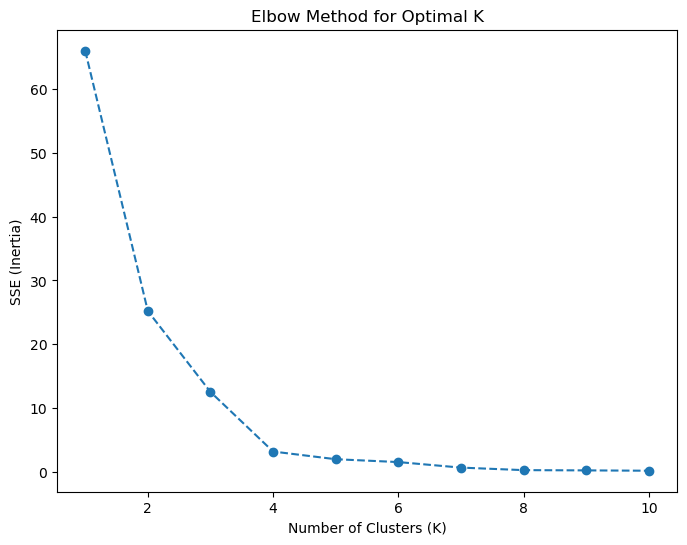

In [17]:
cluster_data = accident[['accident_density_z','casualty_rate_z']]
sse = []

k_range = range(1, 11) 
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(cluster_data)
    sse.append(kmeans.inertia_) 

sse_diff = np.diff(sse) 
sse_se = np.std(sse_diff)  

plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE (Inertia)')
plt.show()

In [18]:
kmeans = KMeans(n_clusters=4, random_state=42)
accident['Cluster'] = kmeans.fit_predict(accident[['accident_density_z','casualty_rate_z']])

<function matplotlib.pyplot.show(close=None, block=None)>

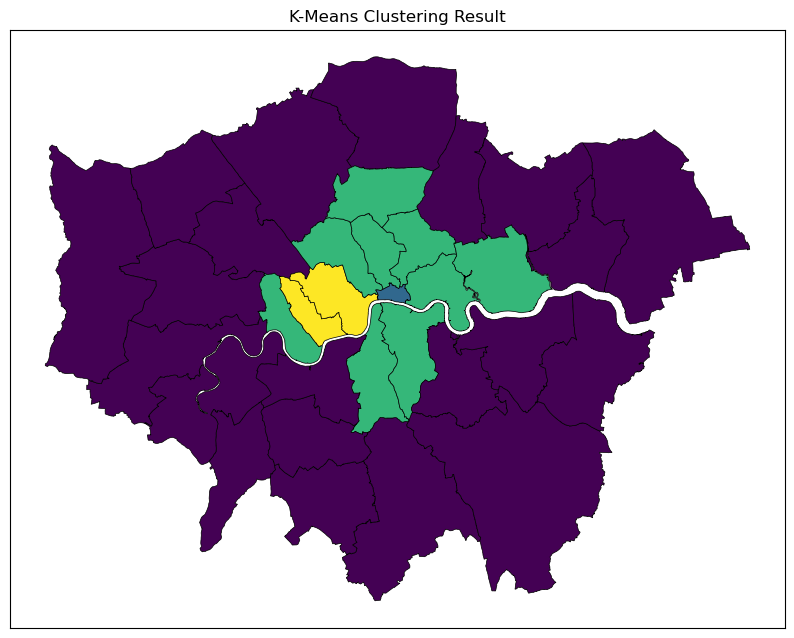

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
accident.plot(column='Cluster', cmap='viridis', legend=False, ax=ax,edgecolor='black', linewidth=0.5)
ax.set_xticks([])  
ax.set_yticks([])  
plt.title("K-Means Clustering Result")
plt.show

In [9]:
!pip install odfpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160673 sha256=b9cfd4dad3dcb95b63faec85e3bf983e8b695cae819dec3734f2569e5be63df8
  Stored in directory: /home/jovyan/.cache/pip/wheels/d6/1d/c8/8c29be1d73ca42d15977c75193d9f39a98499413c2838ac54c
Successfully built odfpy


In [10]:
car_types = pd.read_excel('vehicles-licensed-type-borough (2).xls', sheet_name='2023', skiprows=[1])
road_length = pd.read_excel('rdl0102-archived.ods', sheet_name='RDL0102a_(2020)', engine='odf', skiprows=6)
traffic_flow = pd.read_excel('traffic-flow-borough.xls', sheet_name='Traffic Flows - All vehicles')
traffic_flow = traffic_flow.dropna()
speed_limit = gdf_join.groupby('NAME')['speed_limit'].mode().reset_index()

In [11]:
traffic_flow_2023 = traffic_flow[['LA Code', 'Local Authority',2023]]
population_density = pd.read_csv('housing-density-borough.csv')
density_2023 = population_density[population_density['Year'] == 2023][['Code', 'Name', 'Population', 'Square_Kilometres', 'Population_per_square_kilometre']]

In [12]:
area_name = density_2023[['Name', 'Square_Kilometres']]
car_type = pd.merge(car_types, area_name, left_on='Local Authority  ', right_on='Name')
label = ['car density', 'motor density', 'light density', 'heavy density', 'bus density', 'other density']
for i, c in enumerate(car_type.iloc[:,3:9].columns):
    car_type[label[i]] = car_type[c]*1000/car_type['Square_Kilometres']
car_density = car_type[['ONS CHD LA Code', 'Local Authority  ','car density', 'motor density', 'light density', 'heavy density', 'bus density', 'other density']]

In [13]:
ped_count = gdf_join['NAME'].value_counts().reset_index()
ped_count_2023 = pd.merge(ped_count, area_name, left_on='NAME', right_on='Name')
ped_count_2023['accident density']=ped_count_2023['count']/ped_count_2023['Square_Kilometres']

In [14]:
road_length = road_length.iloc[:, list(range(21, 24)) + [2]].copy()
road_london = pd.merge(road_length, area_name, left_on='Local authority', right_on='Name')

In [15]:
labels = ['major principal density', 'minor density', 'total density']
for i, c in enumerate(road_london.iloc[:,0:3].columns):
    road_london[labels[i]] = road_london[c]*1000/road_london['Square_Kilometres']
length_density = road_london[['Name','major principal density', 'minor density', 'total density']]

In [31]:
flow_2023 = traffic_flow[['LA Code', 'Local Authority', 2023]].iloc[:33,:]

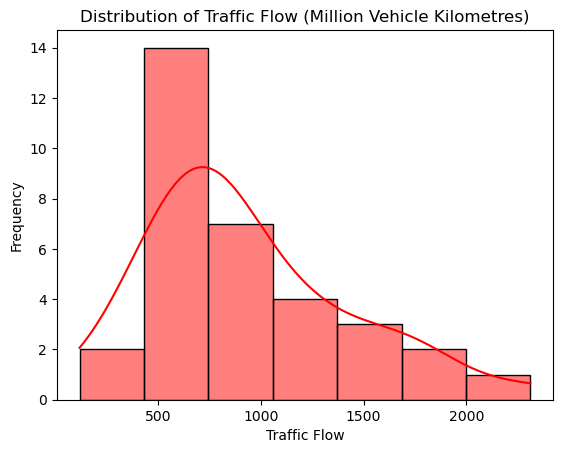

In [41]:
sns.histplot(flow_2023[2023], kde=True, color='red')
plt.title("Distribution of Traffic Flow (Million Vehicle Kilometres)")
plt.xlabel("Traffic Flow")
plt.ylabel("Frequency")
plt.show()

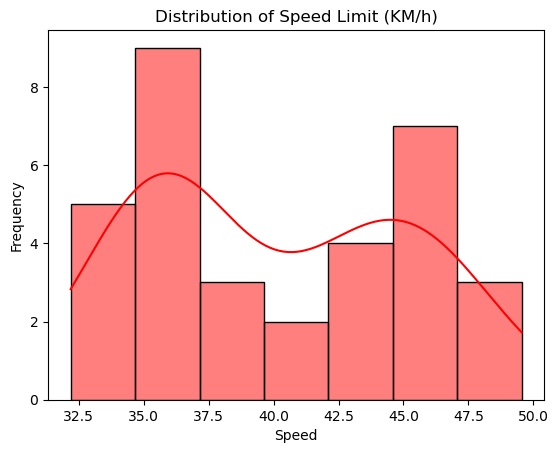

In [49]:
speed_limit['speed_limit']=speed_limit['speed_limit']*1.60934
sns.histplot(speed_limit['speed_limit'], kde=True, color='red')
plt.title("Distribution of Speed Limit (KM/h)")
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.show()

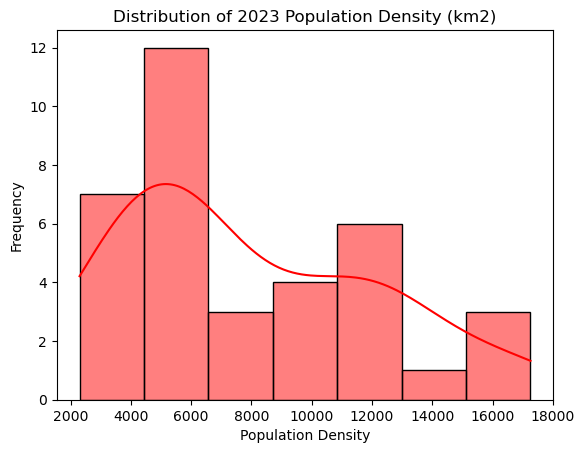

In [54]:
sns.histplot(density_2023['Population_per_square_kilometre'], kde=True, color='red')
plt.title("Distribution of 2023 Population Density (km2)")
plt.xlabel("Population Density")
plt.ylabel("Frequency")
plt.show()

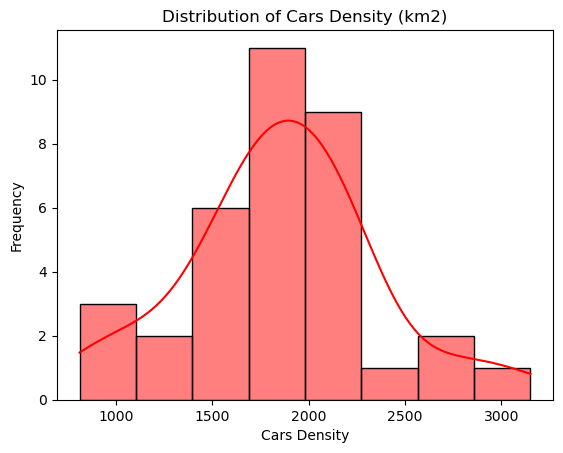

In [56]:
sns.histplot(car_density['car density'], kde=True, color='red')
plt.title("Distribution of Cars Density (km2)")
plt.xlabel("Cars Density")
plt.ylabel("Frequency")
plt.show()

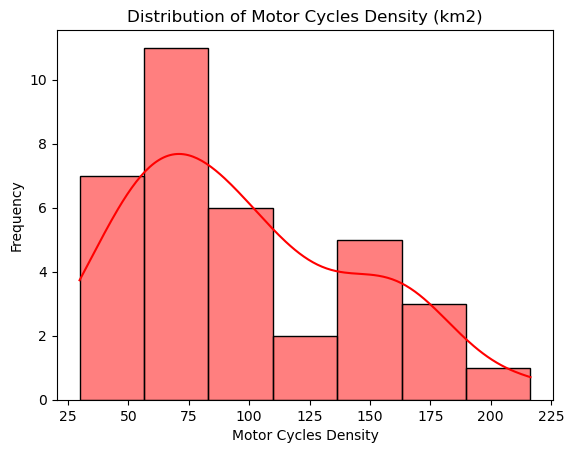

In [57]:
sns.histplot(car_density['motor density'], kde=True, color='red')
plt.title("Distribution of Motor Cycles Density (km2)")
plt.xlabel("Motor Cycles Density")
plt.ylabel("Frequency")
plt.show()

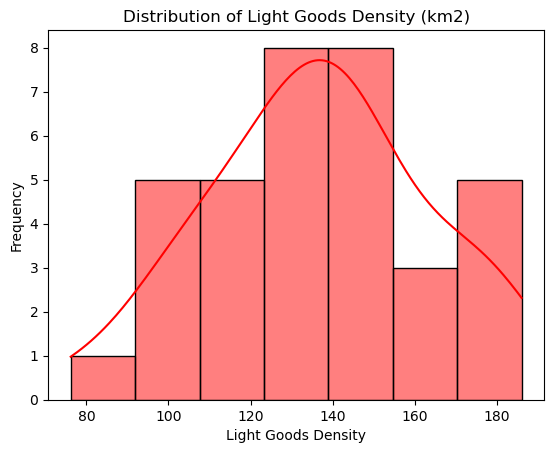

In [58]:
sns.histplot(car_density['light density'], kde=True, color='red')
plt.title("Distribution of Light Goods Density (km2)")
plt.xlabel("Light Goods Density")
plt.ylabel("Frequency")
plt.show()

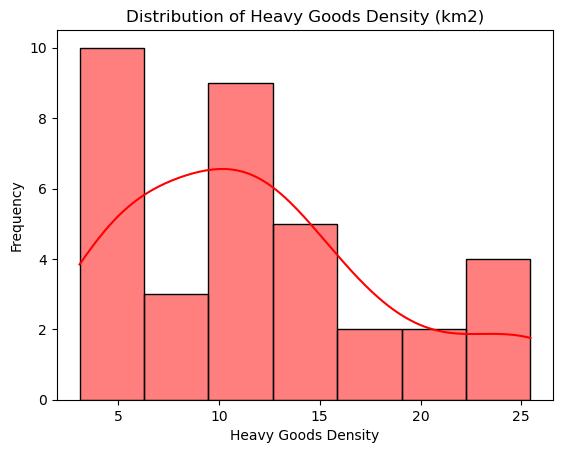

In [59]:
sns.histplot(car_density['heavy density'], kde=True, color='red')
plt.title("Distribution of Heavy Goods Density (km2)")
plt.xlabel("Heavy Goods Density")
plt.ylabel("Frequency")
plt.show()

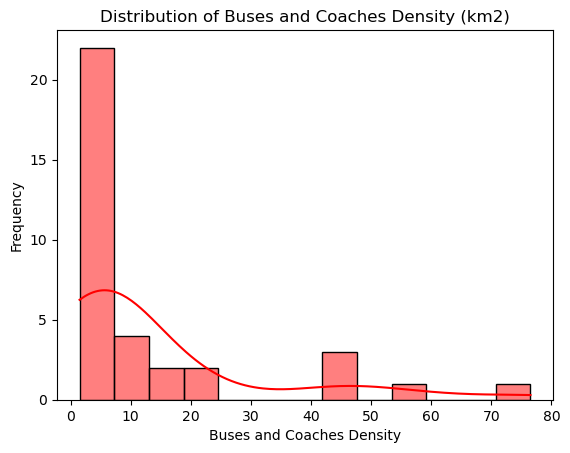

In [60]:
sns.histplot(car_density['bus density'], kde=True, color='red')
plt.title("Distribution of Buses and Coaches Density (km2)")
plt.xlabel("Buses and Coaches Density")
plt.ylabel("Frequency")
plt.show()

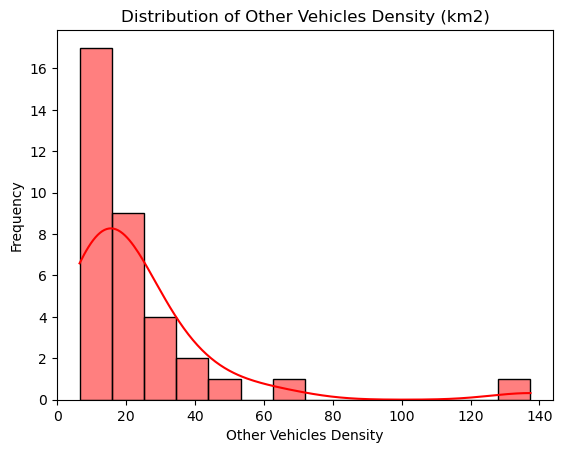

In [62]:
sns.histplot(car_density['other density'], kde=True, color='red')
plt.title("Distribution of Other Vehicles Density (km2)")
plt.xlabel("Other Vehicles Density")
plt.ylabel("Frequency")
plt.show()

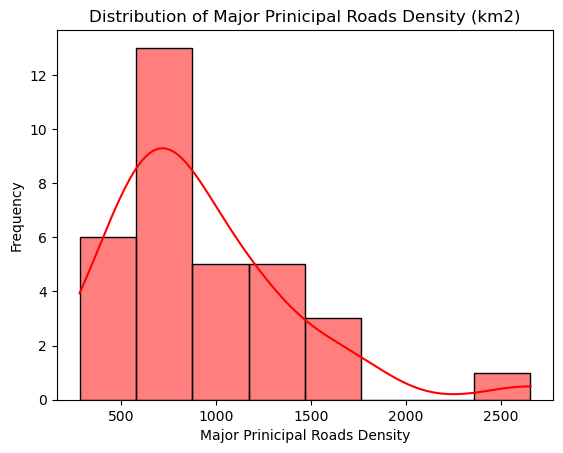

In [65]:
length_density.head(33) 
sns.histplot(length_density['major principal density'], kde=True, color='red')
plt.title("Distribution of Major Prinicipal Roads Density (km2)")
plt.xlabel("Major Prinicipal Roads Density")
plt.ylabel("Frequency")
plt.show()

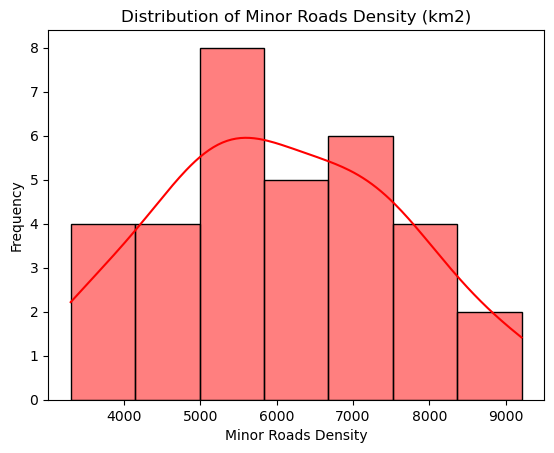

In [66]:
sns.histplot(length_density['minor density'], kde=True, color='red')
plt.title("Distribution of Minor Roads Density (km2)")
plt.xlabel("Minor Roads Density")
plt.ylabel("Frequency")
plt.show()

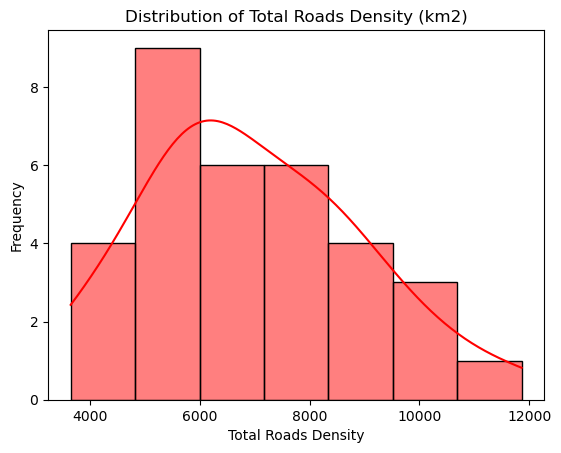

In [67]:
sns.histplot(length_density['total density'], kde=True, color='red')
plt.title("Distribution of Total Roads Density (km2)")
plt.xlabel("Total Roads Density")
plt.ylabel("Frequency")
plt.show()

In [72]:
ped_density_2023=ped_count_2023[['NAME', 'accident density']]
combine1 = pd.merge(ped_density_2023, speed_limit, on='NAME')
combine2 = pd.merge(combine1, car_density, left_on="NAME", right_on='Local Authority  ')
combine3 = pd.merge(combine2, density_2023, left_on="NAME", right_on="Name")
combine4 = pd.merge(combine3, length_density, left_on="NAME", right_on="Name")
combine5 = pd.merge(combine4, flow_2023, left_on="NAME", right_on='Local Authority')
combine5 = combine5.rename(columns={2023: 'traffic flow'})
regression_all = combine5[['NAME', 'accident density','speed_limit','car density','motor density','light density','heavy density','bus density','other density','Population_per_square_kilometre','major principal density','minor density','total density','traffic flow']]

In [90]:
regression_all.head()

NAME  accident density  speed_limit  car density  motor density  \
0  Westminster         15.534884    34.162337  2813.720930      98.372093   
1      Lambeth          7.574627    38.370471  2247.500000     167.537313   
2      Croydon          2.300578    41.891363  1564.069364      72.161850   
3       Newham          5.248619    42.774563  1877.679558     108.425414   
4    Southwark          6.228374    36.836004  1903.183391     162.664360   

   light density  heavy density  bus density  other density  \
0     172.046512       8.325581    14.837209      64.139535   
1     143.992537       4.216418     3.470149      14.216418   
2     120.693642       4.786127     2.647399       6.520231   
3     138.232044      14.116022    47.403315      21.933702   
4     129.100346       4.498270    45.605536      18.131488   

   Population_per_square_kilometre  major principal density  minor density  \
0                          12438.9              1739.534884    8009.302326   
1                          12878.9              1272.388060    7470.149254   
2                           4758.0               561.849711    5018.497110   
3                          10290.9               933.701657    6436.464088   
4                          11660.8              1183.391003    7221.453287   

  total density  traffic flow  
0   9748.837209         721.5  
1   8742.537313         737.6  
2   5580.346821        1335.4  
3   7370.165746         891.6  
4   8404.844291         692.1